![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics

# Günther-Salzer model

\begin{align}
    \dot{\epsilon}_\text{cr} &= \dot{\epsilon}_\text{cr}^\text{V} + \dot{\epsilon}_\text{cr}^\text{E}
    \\
    \dot{\epsilon}_\text{cr} &= A_\text{p} \frac{ (\bar{\sigma}/\sigma_\text{ref})^{n_\text{p}}}{\left( \epsilon^\text{V}_0 + \epsilon_\text{cr}^\text{V} \right)^{\mu_\text{p}}} \quad \text{with} \quad \bar{\sigma} = \sqrt{\frac{3}{2}} \left\lVert \mathbf{s} \right\rVert
    \\
    \dot{\epsilon}_\text{cr}^\text{E} &= \sum \limits_{i=1}^2 A_{\text{s},i} \exp \left( - \frac{Q_i}{RT} \right) \left( \frac{\bar{\sigma}}{\sigma_\text{ref}} \right)^{n_i}
\end{align}

3D:

$$
    \dot{\boldsymbol\epsilon}_\text{cr} = \sqrt{\frac{3}{2}} \dot{\epsilon}_\text{cr} \frac{\mathbf{s}}{\left\lVert \mathbf{s} \right\rVert}
$$

In [1]:
#HIDDEN
import mtest
import numpy as np
import matplotlib.pyplot as plt
import os
import plot_settings
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)

In [2]:
E = 25e4 #MPa
nu = 0.27
#
Ap = 6.5e-24 #1/d
npe = 11.88
s0 = 1.0 #MPa
mup = 2.95
epsv0 = 0.01 # very sensitive parameter!
#
As1 = 0.05
Q1 = 40e3
ns1 = 2.7
As2 = 0.02
Q2 = 65e3
ns2 = 6.8

In [3]:
build_release = 'mfront --obuild --interface=generic GuentherSalzer.mfront'
os.system(build_release)

Treating target : all
The following library has been built :
- libBehaviour.so :  MohrCoulombAbboSloan_AxisymmetricalGeneralisedPlaneStrain MohrCoulombAbboSloan_AxisymmetricalGeneralisedPlaneStress MohrCoulombAbboSloan_Axisymmetrical MohrCoulombAbboSloan_PlaneStress MohrCoulombAbboSloan_PlaneStrain MohrCoulombAbboSloan_GeneralisedPlaneStrain MohrCoulombAbboSloan_Tridimensional ModCamClay_semiExplParaInit_AxisymmetricalGeneralisedPlaneStrain ModCamClay_semiExplParaInit_AxisymmetricalGeneralisedPlaneStress ModCamClay_semiExplParaInit_Axisymmetrical ModCamClay_semiExplParaInit_PlaneStress ModCamClay_semiExplParaInit_PlaneStrain ModCamClay_semiExplParaInit_GeneralisedPlaneStrain ModCamClay_semiExplParaInit_Tridimensional Lubby2mod_AxisymmetricalGeneralisedPlaneStrain Lubby2mod_AxisymmetricalGeneralisedPlaneStress Lubby2mod_Axisymmetrical Lubby2mod_PlaneStress Lubby2mod_PlaneStrain Lubby2mod_GeneralisedPlaneStrain Lubby2mod_Tridimensional PowerLawLinearCreep_AxisymmetricalGeneralisedPlaneSt

0

In [4]:
#HIDDEN
def run_creep_IfG(t_discrete, sdiff=-25):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', './src/libBehaviour.so', 'GuentherSalzer')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStress('SZZ', {0: 0, 1:-16, 60: -16, 61: sdiff, 200: sdiff})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PrimaryPowerLawFactor', Ap)
    m.setMaterialProperty('PrimaryPowerLawExponent', npe)
    m.setMaterialProperty('SecondaryPowerLawFactor1', As1)
    m.setMaterialProperty('SecondaryPowerLawExponent1', ns1)
    m.setMaterialProperty('SecondaryActivationEnergy1', Q1)
    m.setMaterialProperty('SecondaryPowerLawFactor2', As2)
    m.setMaterialProperty('SecondaryPowerLawExponent2', ns2)
    m.setMaterialProperty('SecondaryActivationEnergy2', Q2)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', epsv0)
    m.setMaterialProperty('ReferenceStress', s0)
    m.setExternalStateVariable("Temperature", 293.15)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[2])
    return numerical

In [5]:
#HIDDEN
ndt = 200
times = np.append(np.linspace(0,10,ndt),
                  np.append(
                      np.linspace(11,60,ndt),
                      np.append(
                          np.linspace(60.1,70,ndt),
                          np.linspace(71,200,ndt)
                      )
                  )
                 )

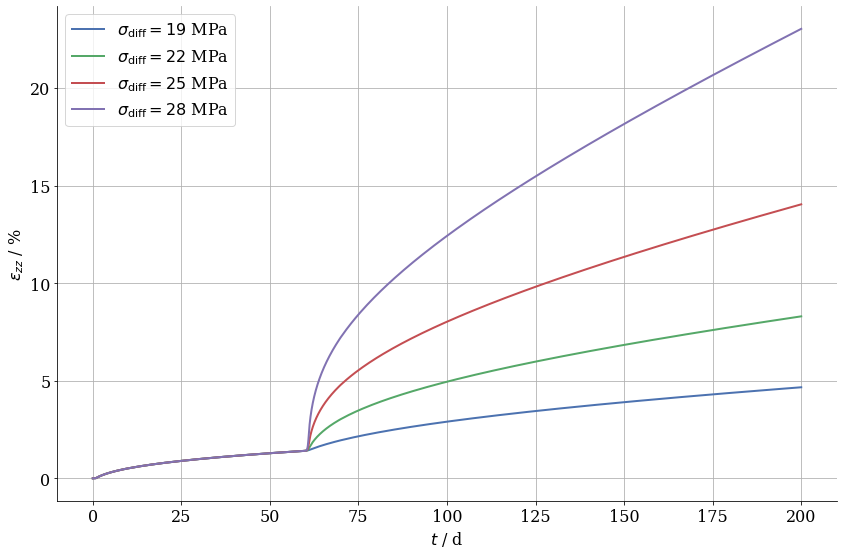

In [6]:
#HIDDEN
sigs = [-19,-22,-25,-28]
fig,ax = plt.subplots(figsize=(12,8))
for sig in sigs:
    ax.plot(times[1:],-run_creep_IfG(times,sig)[1:]*100,label='$\\sigma_\\mathrm{diff} = %i$ MPa' %(-sig))
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\epsilon_{zz}$ / %')
ax.grid('both')
ax.legend();
fig.tight_layout();

In [7]:
#HIDDEN
def run_creep_BMBF(t_discrete):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', './src/libBehaviour.so', 'GuentherSalzer')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStress('SZZ', {0: 0, 1: -20, 60: -20, 61: -15, 150: -15, 151: -20, 170:-20, 171: -18, 380: -18, 381: -20, 450: -20})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PrimaryPowerLawFactor', Ap)
    m.setMaterialProperty('PrimaryPowerLawExponent', npe)
    m.setMaterialProperty('SecondaryPowerLawFactor1', As1)
    m.setMaterialProperty('SecondaryPowerLawExponent1', ns1)
    m.setMaterialProperty('SecondaryActivationEnergy1', Q1)
    m.setMaterialProperty('SecondaryPowerLawFactor2', As2)
    m.setMaterialProperty('SecondaryPowerLawExponent2', ns2)
    m.setMaterialProperty('SecondaryActivationEnergy2', Q2)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', epsv0)
    m.setMaterialProperty('ReferenceStress', s0)
    m.setExternalStateVariable("Temperature", 293.15)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[2])
    return numerical

In [8]:
times = np.linspace(0,450,10000)

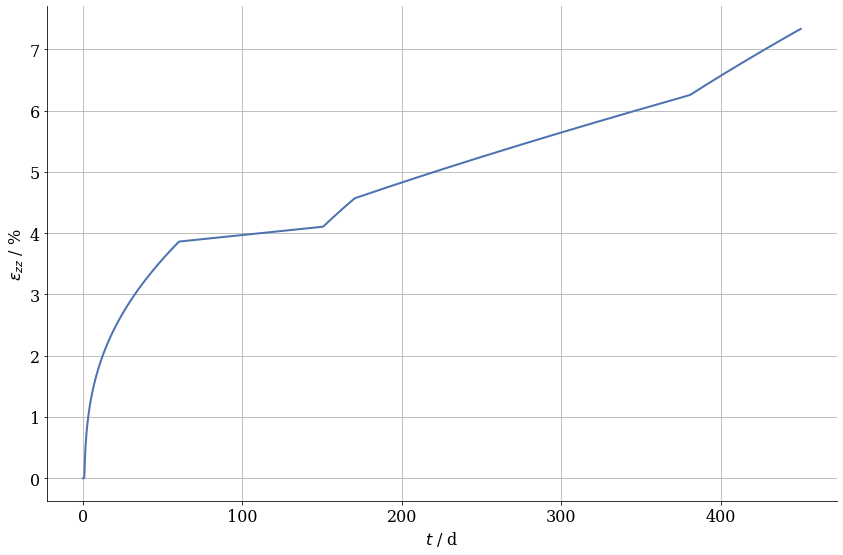

In [9]:
#HIDDEN
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times[1:],-run_creep_BMBF(times)[1:]*100)
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\epsilon_{zz}$ / %')
ax.grid('both')
fig.tight_layout();

In [10]:
E = 25e4 #MPa
nu = 0.27
#
Ap = 5.5e-40 #1/d
npe = 19.6
s0 = 1.0 #MPa
mup = 5.25
epsv0 = 0.001 # very sensitive parameter!
#
As1 = 0.05
Q1 = 40e3
ns1 = 2.7
As2 = 0.02
Q2 = 65e3
ns2 = 6.8

In [11]:
#HIDDEN
def run_creep_Asse(T = 299, t1=45, t2 = 30, sdiff1=-25, sdiff2 = -25, s3 = -20.):
    t_discrete = np.linspace(0,t1+t2,1000)
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', './src/libBehaviour.so', 'GuentherSalzer')
    m.setImposedStress('SXX', s3)
    m.setImposedStress('SYY', s3)
    m.setImposedStress('SZZ', {0: s3, 1:s3+sdiff1, t1: s3+sdiff1, t1+1: s3+sdiff2, t2+t1: s3+sdiff2})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PrimaryPowerLawFactor', Ap)
    m.setMaterialProperty('PrimaryPowerLawExponent', npe)
    m.setMaterialProperty('SecondaryPowerLawFactor1', As1)
    m.setMaterialProperty('SecondaryPowerLawExponent1', ns1)
    m.setMaterialProperty('SecondaryActivationEnergy1', Q1)
    m.setMaterialProperty('SecondaryPowerLawFactor2', As2)
    m.setMaterialProperty('SecondaryPowerLawExponent2', ns2)
    m.setMaterialProperty('SecondaryActivationEnergy2', Q2)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', epsv0)
    m.setMaterialProperty('ReferenceStress', s0)
    m.setExternalStateVariable("Temperature", 293.15)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[2])
    return t_discrete, numerical

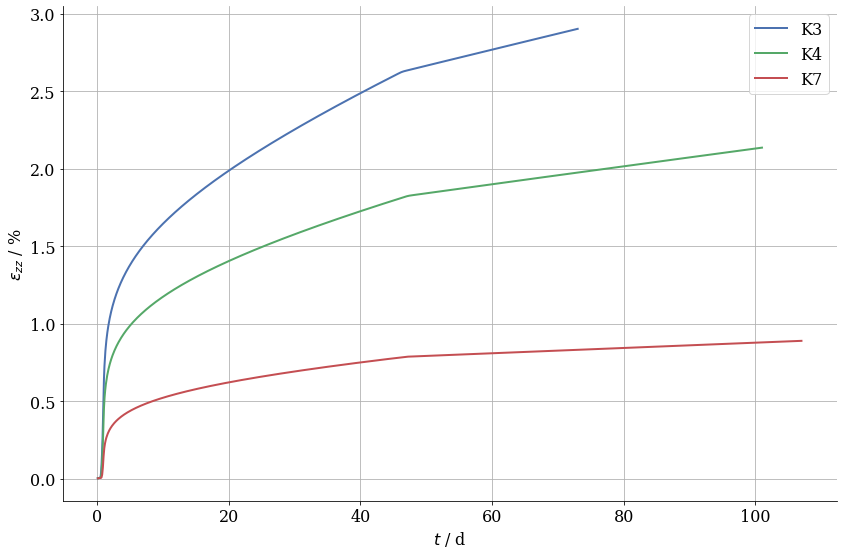

In [12]:
#HIDDEN
fig,ax = plt.subplots(figsize=(12,8))
t3, e3 = run_creep_Asse(T = 333, t1 = 46, t2 = 27, sdiff1 = -22, sdiff2 = -20, s3 = -20)
t4, e4 = run_creep_Asse(T = 333, t1 = 47, t2 = 54, sdiff1 = -20, sdiff2 = -18, s3 = -20)
t7, e7 = run_creep_Asse(T = 333, t1 = 47, t2 = 60, sdiff1 = -16, sdiff2 = -14, s3 = -20)
ax.plot(t3[1:],-e3[1:]*100, label= 'K3')
ax.plot(t4[1:],-e4[1:]*100, label= 'K4')
ax.plot(t7[1:],-e7[1:]*100, label= 'K7')
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\epsilon_{zz}$ / %')
ax.grid('both')
ax.legend()
fig.tight_layout();

In [13]:
#HIDDEN
def run_stress_effect_sim(t_discrete, sax, T):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', './src/libBehaviour.so', 'GuentherSalzer')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStress('SZZ', {0:0, 1:sax})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PrimaryPowerLawFactor', Ap)
    m.setMaterialProperty('PrimaryPowerLawExponent', npe)
    m.setMaterialProperty('SecondaryPowerLawFactor1', As1)
    m.setMaterialProperty('SecondaryPowerLawExponent1', ns1)
    m.setMaterialProperty('SecondaryActivationEnergy1', Q1)
    m.setMaterialProperty('SecondaryPowerLawFactor2', As2)
    m.setMaterialProperty('SecondaryPowerLawExponent2', ns2)
    m.setMaterialProperty('SecondaryActivationEnergy2', Q2)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', epsv0)
    m.setMaterialProperty('ReferenceStress', s0)
    m.setExternalStateVariable("Temperature", T)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    prev = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[2])
        prev = np.append(prev,s.e0[2])
    return numerical, prev

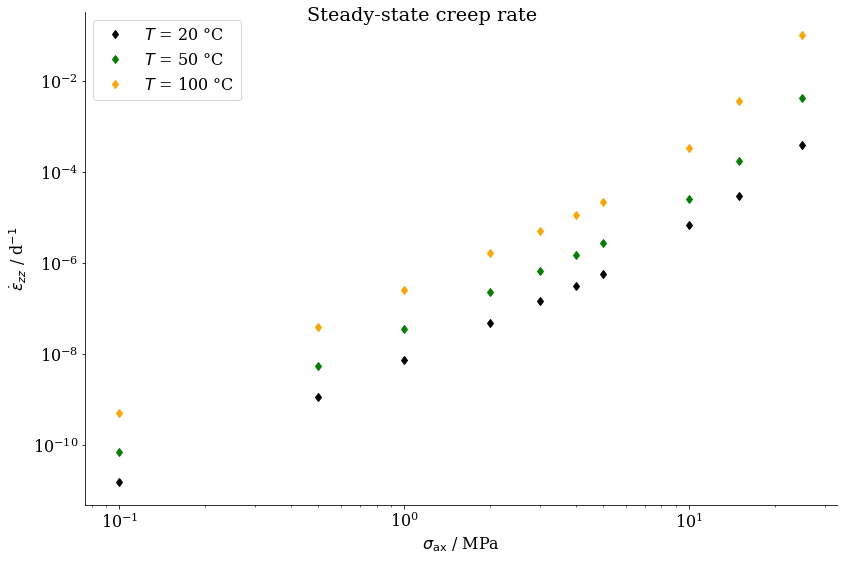

In [14]:
#HIDDEN
times = np.linspace(0,100,1000)
sax = [0.1,0.5,1,2,3,4,5,10,15,25]
temps = [20,50,100]
cols = ['black','green','orange','red']
fig,ax = plt.subplots(figsize=(12,8))
for s in sax:
    for i,T in enumerate(temps):
        eps1, eps0 = run_stress_effect_sim(times,s,T+273.15)
        dot_eps_av = (eps1[-1]-eps0[-1])/(times[-1] - times[-2])
        if s == sax[0]:
            ax.plot(s,dot_eps_av,label='$T$ = %i °C' %T, ls='', marker='d',color=cols[i])
        else:
            ax.plot(s,dot_eps_av, ls='', marker='d',color=cols[i])
ax.set_xlabel('$\\sigma_\\mathrm{ax}$ / MPa')
ax.set_ylabel('$\\dot{\\epsilon}_{zz}$ / d$^{-1}$')
ax.set_xscale('log')
ax.set_yscale('log')
fig.tight_layout();
fig.suptitle('Steady-state creep rate')
ax.legend();